In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

 Clean Rga Data takes the .txt files of the into a pandas dataframe


In [58]:
def clean_rga_data(file_path):
    
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    lines = content.split('\n')
    
    # Find where the data starts (after "Time(s)" header)
    data_start = None
    for i, line in enumerate(lines):
        if 'Time(s)' in line and 'Channel' in line:
            data_start = i + 2  # Skip header and empty line
            break
    
    if data_start is None:
        raise ValueError("Could not find data header in file")
    
    print(f"Found data starting at line {data_start}")
    
    # Extract and clean data lines
    raw_data_lines = lines[data_start:]
    cleaned_lines = []
    
    for i, line in enumerate(raw_data_lines):
        # Remove carriage returns and strip whitespace
        cleaned = line.replace('\r', '').strip()
        
        # Skip empty lines
        if not cleaned or not ',' in cleaned:
            continue
            
        # Remove trailing comma and extra spaces
        cleaned = cleaned.rstrip(', ')
        
        # Split by comma and clean each part
        parts = [part.strip() for part in cleaned.split(',') if part.strip()]
        
        # Should have exactly 3 parts: time, channel1, channel2
        if len(parts) == 3:
            try:
                # Validate that all parts are numbers
                float(parts[0])  # time
                float(parts[1])  # channel 1
                float(parts[2])  # channel 2
                cleaned_lines.append(','.join(parts))
            except ValueError:
                print(f"Skipping line {data_start + i}: invalid numbers - {cleaned}")
        else:
            print(f"Skipping line {data_start + i}: wrong number of columns ({len(parts)}) - {cleaned}")
    
    print(f"Successfully cleaned {len(cleaned_lines)} data lines")
    
    # Create CSV string and read into DataFrame
    csv_content = "Time,Magnesium_24amu,Barium_138amu\n" + '\n'.join(cleaned_lines)
    
    # Read into DataFrame
    df = pd.read_csv(StringIO(csv_content))
    
    # Convert to appropriate data types
    df['Time'] = pd.to_numeric(df['Time'])
    df['Magnesium_24amu'] = pd.to_numeric(df['Magnesium_24amu'])
    df['Barium_138amu'] = pd.to_numeric(df['Barium_138amu'])
    
    # Sort by time to ensure proper ordering
    df = df.sort_values('Time').reset_index(drop=True)
    
    # Check for time sequence issues
    time_diffs = df['Time'].diff()
    negative_diffs = time_diffs[time_diffs <= 0]
    if len(negative_diffs) > 0:
        print(f"Warning: Found {len(negative_diffs)} non-increasing time values")
        print("First few problematic times:")
        for idx in negative_diffs.index[:5]:
            if idx > 0:
                print(f"  Index {idx}: {df.loc[idx-1, 'Time']} -> {df.loc[idx, 'Time']}")
    
    return df

# First Alloy Test using Circuit Layout 2 (rga2.rga)

In [59]:
mass_pre = 315.86 #recordings in grams
mass_load = 315.88
mass_post =315.84 

ambient_temp = 26

amps = np.array ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) # in amperes
time1 = np.array([0, 0.47, 3.19, 7.37, 11.05, 17.35, 21.01, 24.12, 30.44, 35.10, 38.15])
time_s = np.array ([0, 47, 199, 457, 665, 1055, 1261, 1452, 1844, 2110, 2295])
test_1temp = np.array([26, 55.6, 134.3, 237.4, 343.3, 415.9, 476.2, 536.1, 603.1, 646.2, 691.2])
#Pressure recorded on the turbo vacuum
pressure1 = np.array([3.4e-6, 4e-6, 1.4e-5, 4.0e-5, 1.6e-5, 8.6e-6, 6.3e-6, 5.4e-6, 4.6e-6, 4.0e-6, 4.0e-6]) # in mbar
ba_peak_pressure1 = ([5.81e-9, 6.89e-9, 8.41e-9, 2.30e-8, 1.51e-8, 1.76e-8, 1.38e-8, 2.62e-8, 2.66e-7, 8.16e-8, 2.92e-8]) # in Torr


In [60]:
df = clean_rga_data('rga2.txt')
df

Found data starting at line 25
Successfully cleaned 2362 data lines


,Time,Magnesium_24amu,Barium_138amu
0,0.000,1.561300e-08,6.211100e-09
1,0.998,6.452300e-09,4.768800e-09
2,2.012,8.633200e-09,4.392000e-09
3,3.026,5.180900e-09,5.150800e-09
4,4.040,6.809000e-09,4.477400e-09
...,...,...,...
2357,2389.997,7.736200e-08,1.204500e-08
2358,2391.011,7.922600e-08,1.288900e-08
2359,2392.025,7.956800e-08,1.282400e-08
2360,2393.039,7.736200e-08,1.182900e-08


In [61]:
circ1 = np.load('circ1.npy')
circ2 = np.load('circ2.npy')

# Compares the temperature profile of the barium oven with material with the 
# average circuit readings for each thermocouple circuit layout

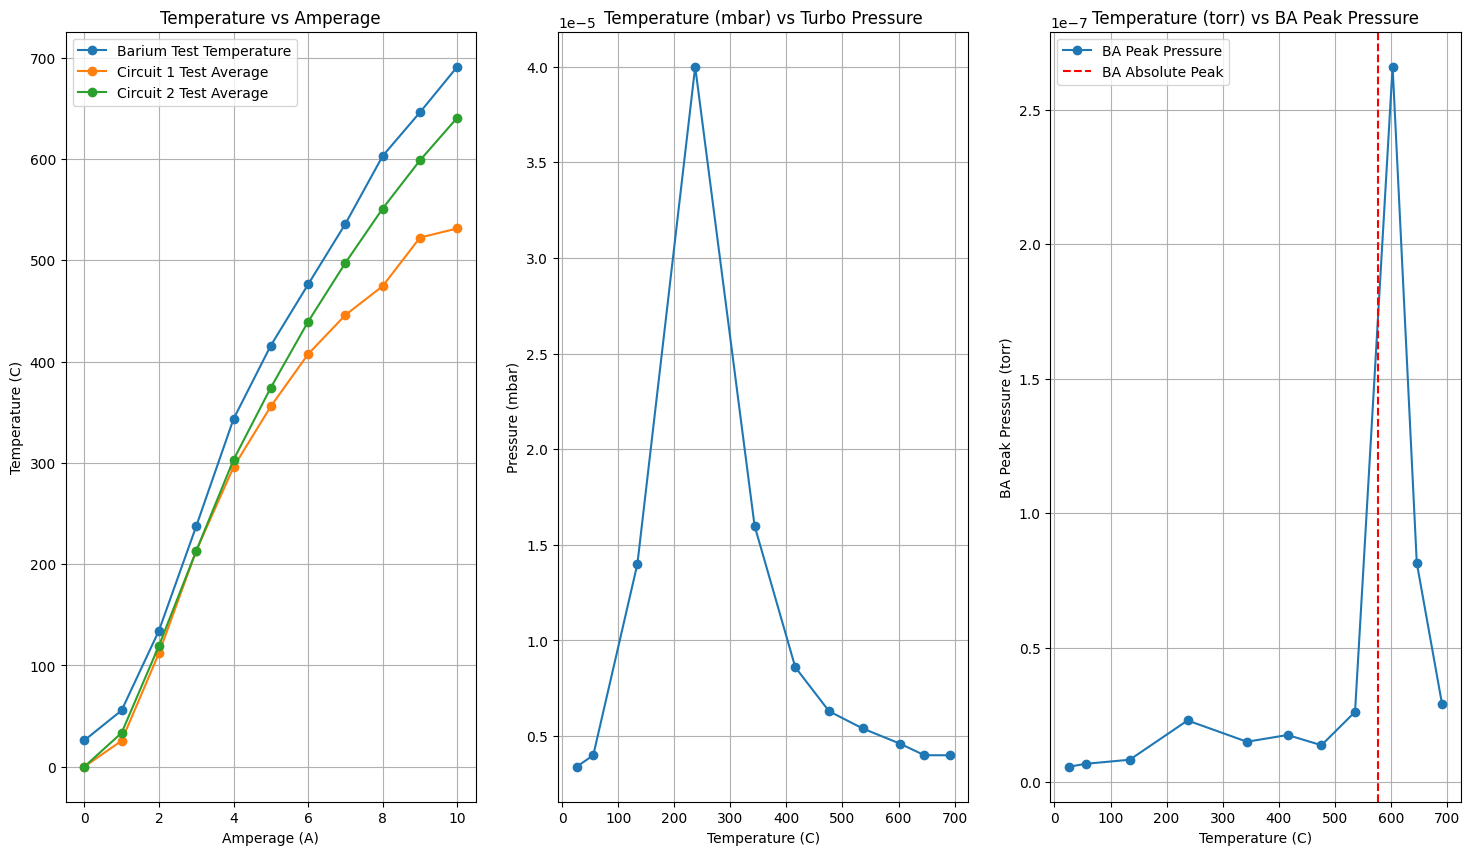

In [62]:
plt.figure(figsize=(18, 10))
plt.subplot(1, 3, 1)
plt.plot(amps, test_1temp, marker='o', linestyle='-', label='Barium Test Temperature')
plt.plot(amps, circ1, marker='o', linestyle='-', label='Circuit 1 Test Average')
plt.plot(amps, circ2, marker='o', linestyle='-', label='Circuit 2 Test Average')
plt.xlabel('Amperage (A)')
plt.ylabel('Temperature (C)')
plt.title('Temperature vs Amperage')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_1temp, pressure1, marker='o', linestyle='-')
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (mbar)')
plt.title('Temperature (mbar) vs Turbo Pressure')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(test_1temp, ba_peak_pressure1, marker='o', linestyle='-', label='BA Peak Pressure')
plt.axvline(x=577.1, color='red', linestyle='--', label='BA Absolute Peak')
plt.xlabel('Temperature (C)')
plt.ylabel('BA Peak Pressure (torr)')
plt.title('Temperature (torr) vs BA Peak Pressure')
plt.grid()
plt.legend()

plt.show()

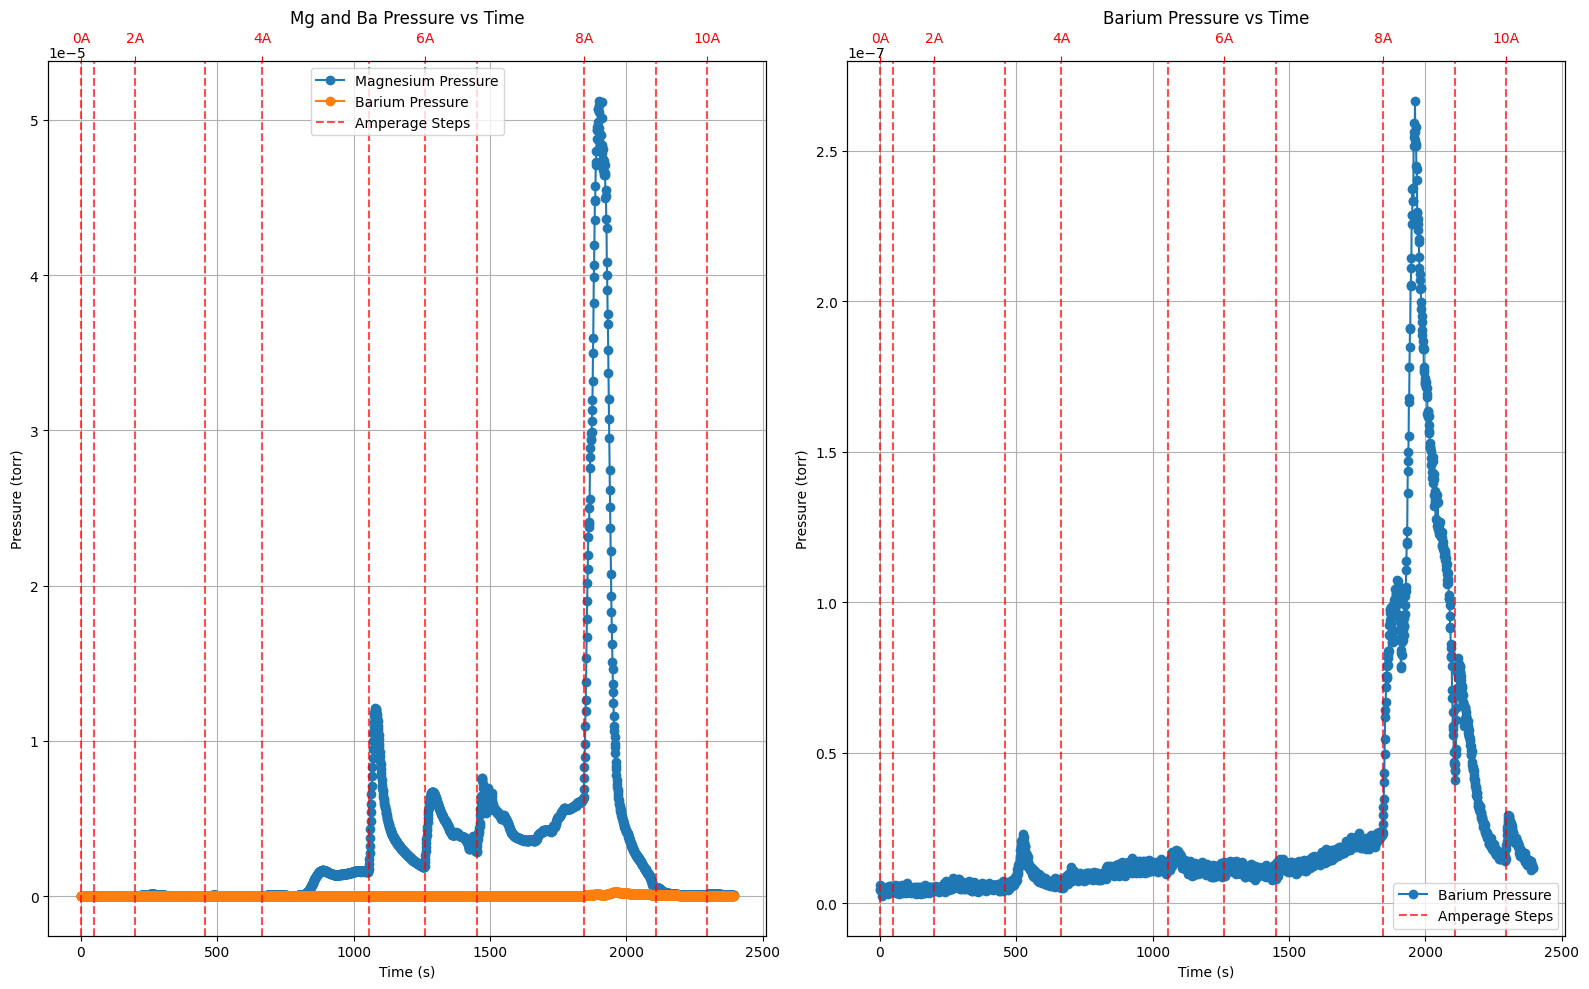

In [63]:
from matplotlib import lines as mlines

plt.figure(figsize=(16, 10))

# Left subplot
plt.subplot(1, 2, 1)
plt.plot(df['Time'], df['Magnesium_24amu'], marker='o', linestyle='-', label='Magnesium Pressure')
plt.plot(df['Time'], df['Barium_138amu'], marker='o', linestyle='-', label='Barium Pressure')

for i, t in enumerate(time_s):
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Pressure (torr)')
plt.title('Mg and Ba Pressure vs Time')
plt.grid()

# Add amperage to legend
amperage_line = mlines.Line2D([], [], color='red', linestyle='--', alpha=0.7, label='Amperage Steps')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(amperage_line)
labels.append('Amperage Steps')
plt.legend(handles=handles, labels=labels)

# Labels the amperage Steps
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
key_indices = [0, 2, 4, 6, 8, 10]  # Show 0A, 2A, 4A, 6A, 8A, 10A
key_times = [time_s[i] for i in key_indices if i < len(time_s)]
key_labels = [f'{i}A' for i in key_indices if i < len(time_s)]
ax2.set_xticks(key_times)
ax2.set_xticklabels(key_labels, fontsize=10)
ax2.tick_params(axis='x', colors='red', pad=8)

# Right subplot
plt.subplot(1, 2, 2)
plt.plot(df['Time'], df['Barium_138amu'], marker='o', linestyle='-', label='Barium Pressure')

for i, t in enumerate(time_s):
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Pressure (torr)')
plt.title('Barium Pressure vs Time')
plt.grid()

# Add amperage to legend
amperage_line = mlines.Line2D([], [], color='red', linestyle='--', alpha=0.7, label='Amperage Steps')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(amperage_line)
labels.append('Amperage Steps')
plt.legend(handles=handles, labels=labels)
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(key_times)
ax2.set_xticklabels(key_labels, fontsize=10)
ax2.tick_params(axis='x', colors='red', pad=8)

plt.tight_layout()
plt.show()

# Second Alloy Test (rga3.rga)

In [64]:
mass_pre_2 = 315.86  # grams
mass_load_2 = 315.87
mass_post_2 = 315.86

ambient_temp_2 = 38.5 # degrees Celsius

time2 = np.array([0, 0.47, 3.19, 7.37, 11.05, 17.35, 21.01, 24.12, 30.44, 35.10, 38.15])
test_2temp = np.array([38.5, 66.6, 158.2, 256.5, 343.9, 403.9, 468.3, 538.6, 584.7, 627.4, 671.5])
pressure2 = np.array([3.4e-6, 4.0e-6, 5.4e-6, 1.0e-5, 1.2e-5, 7.4e-6, 5.4e-6, 3.4e-6, 2.5e-6, 2.5e-6, 2.5e-6]) 
ba_peak_pressure2 = np.array([8.41e-9, 1.08e-8, 1.45e-8, 1.70e-8, 1.57e-8, 2.61e-8, 1.82e-8, 7.02e-8, 6.32e-8, 1.84e-8, 1.40e-8]) 



In [65]:
df2 = clean_rga_data('rga3.txt')
df2

Found data starting at line 25
Successfully cleaned 2336 data lines


,Time,Magnesium_24amu,Barium_138amu
0,0.000,3.527600e-08,5.623100e-09
1,1.014,3.161300e-08,4.944700e-09
2,2.012,2.978400e-08,5.376900e-09
3,3.026,2.914600e-08,6.376900e-09
4,4.040,2.710100e-08,5.512600e-09
...,...,...,...
2331,2363.633,1.210100e-07,1.151800e-08
2332,2364.647,1.230300e-07,1.059800e-08
2333,2365.661,1.210400e-07,9.271400e-09
2334,2366.675,1.189800e-07,9.442200e-09


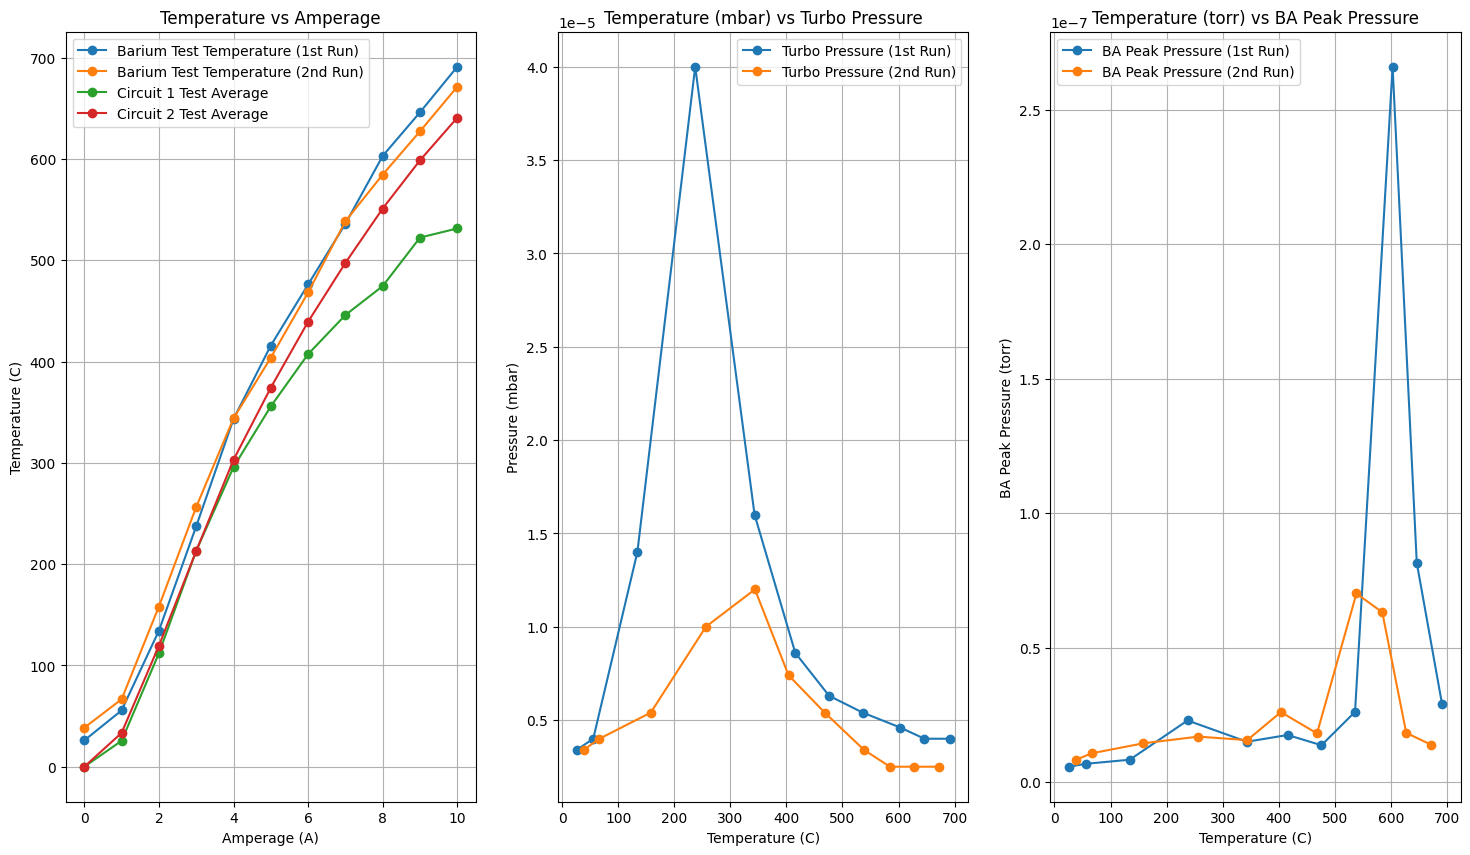

In [66]:
plt.figure(figsize=(18, 10))
plt.subplot(1, 3, 1)
plt.plot(amps, test_1temp, marker='o', linestyle='-', label='Barium Test Temperature (1st Run)')
plt.plot(amps, test_2temp, marker='o', linestyle='-', label='Barium Test Temperature (2nd Run)')
plt.plot(amps, circ1, marker='o', linestyle='-', label='Circuit 1 Test Average')
plt.plot(amps, circ2, marker='o', linestyle='-', label='Circuit 2 Test Average')
plt.xlabel('Amperage (A)')
plt.ylabel('Temperature (C)')
plt.title('Temperature vs Amperage')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_1temp, pressure1, marker='o', linestyle='-', label ='Turbo Pressure (1st Run)')
plt.plot(test_2temp, pressure2, marker='o', linestyle='-', label='Turbo Pressure (2nd Run)')
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (mbar)')
plt.title('Temperature (mbar) vs Turbo Pressure')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_1temp, ba_peak_pressure1, marker='o', linestyle='-', label='BA Peak Pressure (1st Run)')
plt.plot(test_2temp, ba_peak_pressure2, marker='o', linestyle='-', label='BA Peak Pressure (2nd Run)')
plt.xlabel('Temperature (C)')
plt.ylabel('BA Peak Pressure (torr)')
plt.title('Temperature (torr) vs BA Peak Pressure')
plt.grid()
plt.legend()

plt.show()

# Third Alloy Test (rga4.rga)

In [67]:
mass_pre_3 = 315.86 
mass_load_3 = 315.87

ambient_temp_3 = 28  # degrees Celsius

test_3temp = np.array([29, 61.2, 156.4, 253.5, 335.9, 395.0, 453.4, 508.1, 554.2, 591.8, 621.6])
pressure3 = np.array([3.4e-6, 4.0e-6, 4.6e-6, 6.3e-6, 1.2e-5, 1.6e-5, 3.0e-6, 1.9e-6, 1.9e-6, 1.6e-6, 1.6e-6])
ba_peak_pressure3 = np.array([7.68e-9, 6.31e-9, 9.20e-9, 1.14e-8, 1.25e-8, 1.68e-8, 1.76e-8, 2.64e-8, 3.16e-8, 1.93e-8, 1.36e-8])


In [68]:
df3 = clean_rga_data('rga4.txt')
df3

Found data starting at line 25
Successfully cleaned 2336 data lines


,Time,Magnesium_24amu,Barium_138amu
0,0.000,1.420100e-08,5.527600e-09
1,0.998,7.984900e-09,6.115600e-09
2,2.090,6.211100e-09,4.653300e-09
3,3.026,5.331700e-09,5.527600e-09
4,4.040,7.502500e-09,5.758800e-09
...,...,...,...
2331,2363.633,4.220600e-08,1.003500e-08
2332,2364.663,4.333700e-08,1.099500e-08
2333,2365.677,4.193500e-08,1.077900e-08
2334,2366.675,4.476400e-08,1.114100e-08


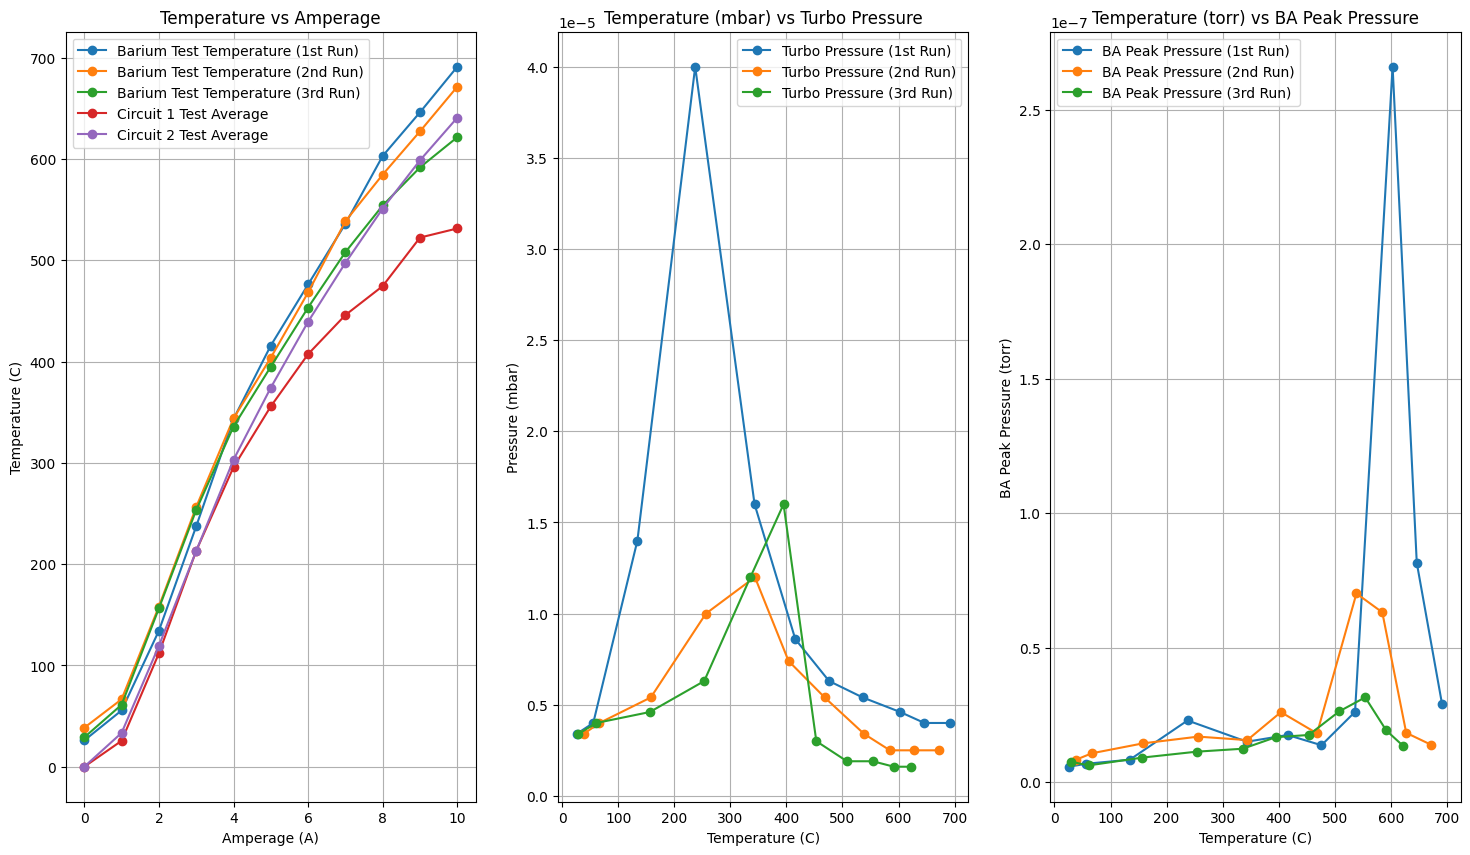

In [69]:
plt.figure(figsize=(18, 10))
plt.subplot(1, 3, 1)
plt.plot(amps, test_1temp, marker='o', linestyle='-', label='Barium Test Temperature (1st Run)')
plt.plot(amps, test_2temp, marker='o', linestyle='-', label='Barium Test Temperature (2nd Run)')
plt.plot(amps, test_3temp, marker='o', linestyle='-', label='Barium Test Temperature (3rd Run)')
plt.plot(amps, circ1, marker='o', linestyle='-', label='Circuit 1 Test Average')
plt.plot(amps, circ2, marker='o', linestyle='-', label='Circuit 2 Test Average')
plt.xlabel('Amperage (A)')
plt.ylabel('Temperature (C)')
plt.title('Temperature vs Amperage')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_1temp, pressure1, marker='o', linestyle='-', label ='Turbo Pressure (1st Run)')
plt.plot(test_2temp, pressure2, marker='o', linestyle='-', label='Turbo Pressure (2nd Run)')
plt.plot(test_3temp, pressure3, marker='o', linestyle='-', label='Turbo Pressure (3rd Run)')
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (mbar)')
plt.title('Temperature (mbar) vs Turbo Pressure')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_1temp, ba_peak_pressure1, marker='o', linestyle='-', label='BA Peak Pressure (1st Run)')
plt.plot(test_2temp, ba_peak_pressure2, marker='o', linestyle='-', label='BA Peak Pressure (2nd Run)')
plt.plot(test_3temp, ba_peak_pressure3, marker='o', linestyle='-', label='BA Peak Pressure (3rd Run)')
plt.xlabel('Temperature (C)')
plt.ylabel('BA Peak Pressure (torr)')
plt.title('Temperature (torr) vs BA Peak Pressure')
plt.grid()
plt.legend()

plt.show()

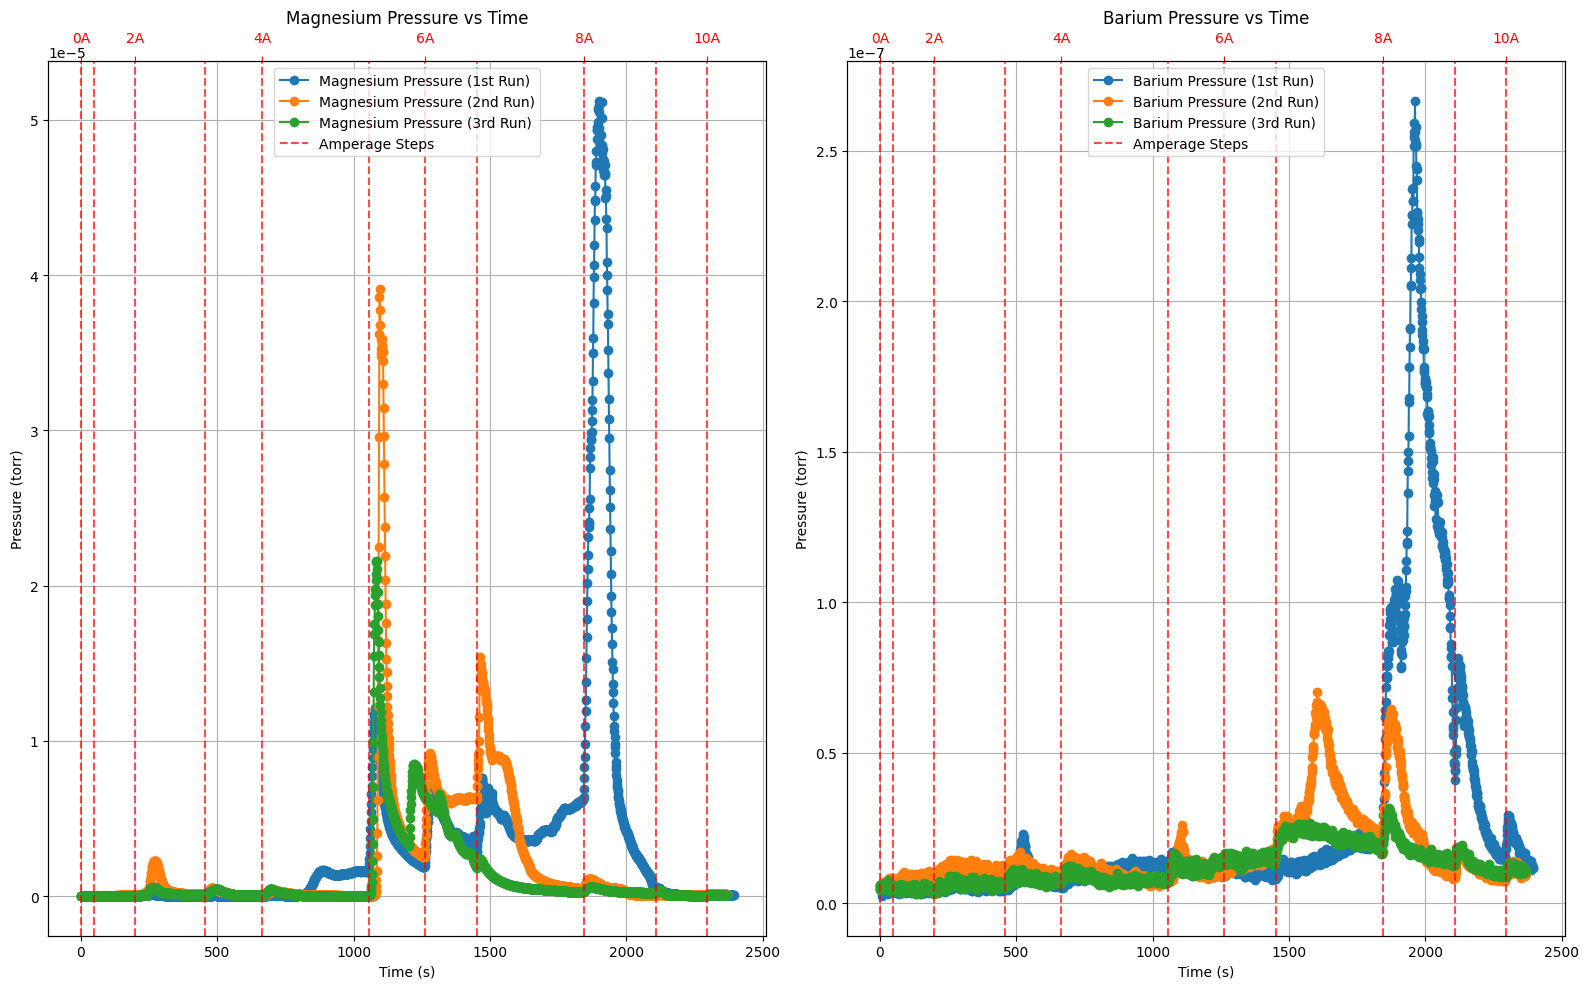

In [70]:
plt.figure(figsize=(16, 10))

# Left subplot
plt.subplot(1, 2, 1)
plt.plot(df['Time'], df['Magnesium_24amu'], marker='o', linestyle='-', label='Magnesium Pressure (1st Run)')
plt.plot(df2['Time'], df2['Magnesium_24amu'], marker='o', linestyle='-', label='Magnesium Pressure (2nd Run)')
plt.plot(df3['Time'], df3['Magnesium_24amu'], marker='o', linestyle='-', label='Magnesium Pressure (3rd Run)')

for i, t in enumerate(time_s):
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Pressure (torr)')
plt.title('Magnesium Pressure vs Time')
plt.grid()

# Add amperage to legend
amperage_line = mlines.Line2D([], [], color='red', linestyle='--', alpha=0.7, label='Amperage Steps')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(amperage_line)
labels.append('Amperage Steps')
plt.legend(handles=handles, labels=labels)

# Labels the amperage Steps
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
key_indices = [0, 2, 4, 6, 8, 10]  # Show 0A, 2A, 4A, 6A, 8A, 10A
key_times = [time_s[i] for i in key_indices if i < len(time_s)]
key_labels = [f'{i}A' for i in key_indices if i < len(time_s)]
ax2.set_xticks(key_times)
ax2.set_xticklabels(key_labels, fontsize=10)
ax2.tick_params(axis='x', colors='red', pad=8)

# Right subplot
plt.subplot(1, 2, 2)
plt.plot(df['Time'], df['Barium_138amu'], marker='o', linestyle='-', label='Barium Pressure (1st Run)')
plt.plot(df2['Time'], df2['Barium_138amu'], marker='o', linestyle='-', label='Barium Pressure (2nd Run)')
plt.plot(df3['Time'], df3['Barium_138amu'], marker='o', linestyle='-', label='Barium Pressure (3rd Run)')

for i, t in enumerate(time_s):
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Pressure (torr)')
plt.title('Barium Pressure vs Time')
plt.grid()

# Add amperage to legend
amperage_line = mlines.Line2D([], [], color='red', linestyle='--', alpha=0.7, label='Amperage Steps')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(amperage_line)
labels.append('Amperage Steps')
plt.legend(handles=handles, labels=labels)
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(key_times)
ax2.set_xticklabels(key_labels, fontsize=10)
ax2.tick_params(axis='x', colors='red', pad=8)

plt.tight_layout()
plt.show()

# Pure Barium Test

In [71]:
ambient_temp_4 = 25.5

test_4temp = np.array([26.7, 58.6, 159.5, 249.6, 325.7, 385.1, 451.9, 478.3, 490.5, 536.6, 576.9])
pressure4 = np.array([4.6e-6, 4.6e-6, 5.4e-6, 4.6e-6, 1.2e-5, 3.4e-6, 4.6e-6, 2.5e-6, 2.2e-6, 1.9e-6, 1.4e-6])
ba_peak_pressure4 = np.array([1.61e-8, 1.91e-8, 2.07e-8, 1.90e-8, 4.18e-7, 1.40e-8, 1.37e-8, 2.16e-8, 4.80e-8, 3.09e-8, 2.03e-7])
 

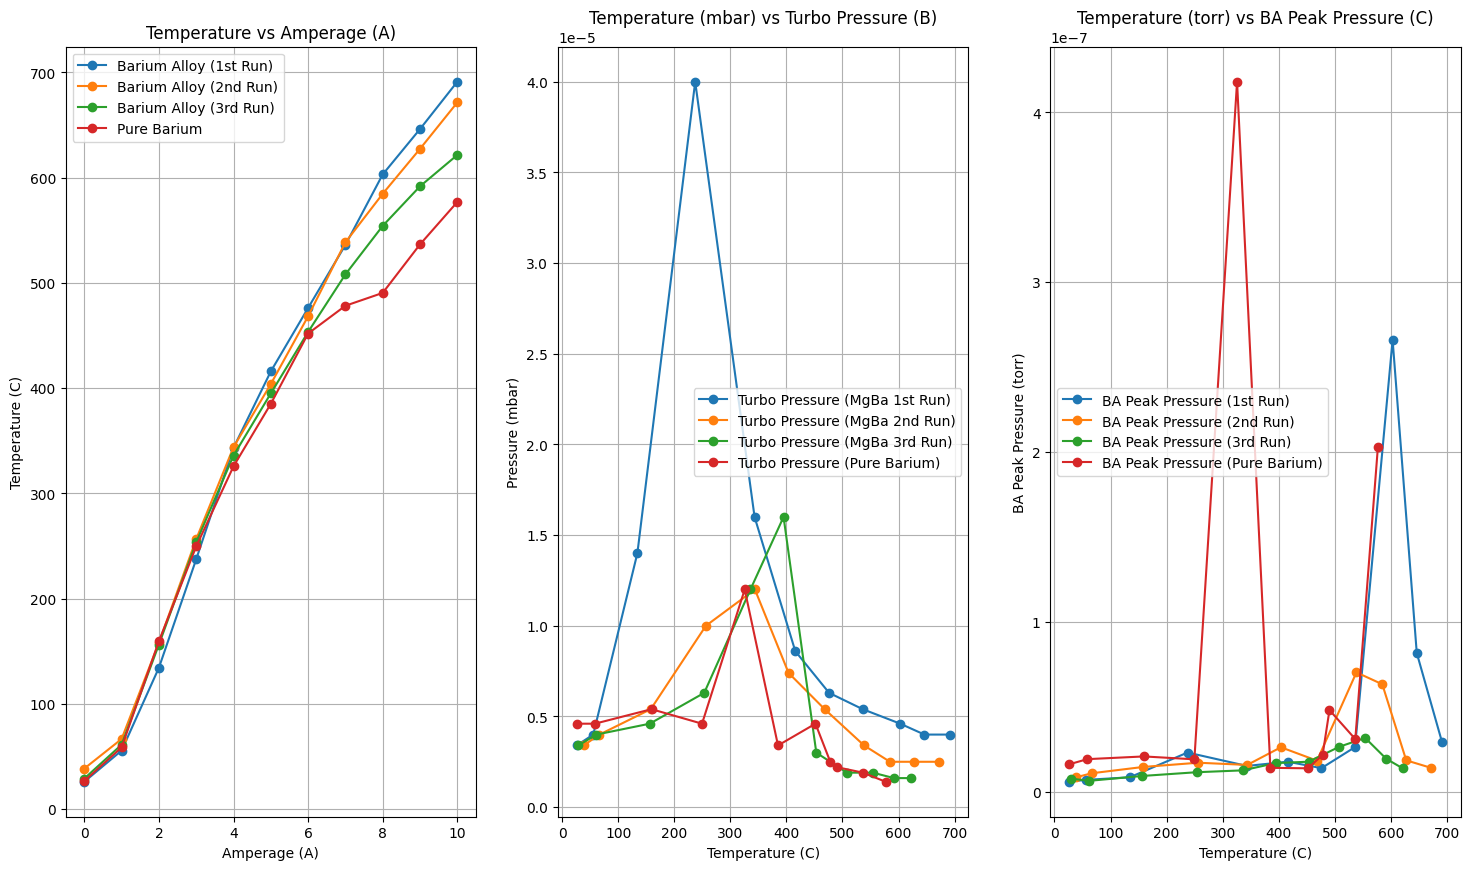

In [72]:
plt.figure(figsize=(18, 10))
plt.subplot(1, 3, 1)
plt.plot(amps, test_1temp, marker='o', linestyle='-', label='Barium Alloy (1st Run)')
plt.plot(amps, test_2temp, marker='o', linestyle='-', label='Barium Alloy (2nd Run)')
plt.plot(amps, test_3temp, marker='o', linestyle='-', label='Barium Alloy (3rd Run)')
plt.plot(amps, test_4temp, marker='o', linestyle='-', label='Pure Barium')
#plt.plot(amps, circ1_average + room_temp, marker='o', linestyle='-', label='Circuit 1 Test Average')
#plt.plot(amps, circ2_average + bake_room_temp, marker='o', linestyle='-', label='Circuit 2 Test Average')
plt.xlabel('Amperage (A)')
plt.ylabel('Temperature (C)')
plt.title('Temperature vs Amperage (A)')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_1temp, pressure1, marker='o', linestyle='-', label ='Turbo Pressure (MgBa 1st Run)')
plt.plot(test_2temp, pressure2, marker='o', linestyle='-', label='Turbo Pressure (MgBa 2nd Run)')
plt.plot(test_3temp, pressure3, marker='o', linestyle='-', label='Turbo Pressure (MgBa 3rd Run)')
plt.plot(test_4temp, pressure4, marker='o', linestyle='-', label='Turbo Pressure (Pure Barium)')
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (mbar)')
plt.title('Temperature (mbar) vs Turbo Pressure (B)')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_1temp, ba_peak_pressure1, marker='o', linestyle='-', label='BA Peak Pressure (1st Run)')
plt.plot(test_2temp, ba_peak_pressure2, marker='o', linestyle='-', label='BA Peak Pressure (2nd Run)')
plt.plot(test_3temp, ba_peak_pressure3, marker='o', linestyle='-', label='BA Peak Pressure (3rd Run)')
plt.plot(test_4temp, ba_peak_pressure4, marker='o', linestyle='-', label='BA Peak Pressure (Pure Barium)')
plt.xlabel('Temperature (C)')
plt.ylabel('BA Peak Pressure (torr)')
plt.title('Temperature (torr) vs BA Peak Pressure (C)')
plt.grid() 
plt.legend()

plt.show()

Had to modify the file reader for the pure barium as it has only the barium readings rather than mg and ba readings.

In [73]:
def clean_barium_rga_data(file_path):

    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    lines = content.split('\n')
    
    # Find where the data starts (after "Time(s)" header)
    data_start = None
    for i, line in enumerate(lines):
        if 'Time(s)' in line and 'Channel' in line:
            data_start = i + 2  # Skip header and empty line
            break
    
    if data_start is None:
        raise ValueError("Could not find data header in file")
    
    print(f"Found data starting at line {data_start}")
    
    # Extract and clean data lines
    raw_data_lines = lines[data_start:]
    cleaned_lines = []
    
    for i, line in enumerate(raw_data_lines):
        # Remove carriage returns and strip whitespace
        cleaned = line.replace('\r', '').strip()
        
        # Skip empty lines
        if not cleaned or not ',' in cleaned:
            continue
            
        # Remove trailing comma and extra spaces
        cleaned = cleaned.rstrip(', ')
        
        # Split by comma and clean each part
        parts = [part.strip() for part in cleaned.split(',') if part.strip()]
        
        # Should have exactly 3 parts: time, channel1, channel2
        if len(parts) == 2:
            try:
                # Validate that all parts are numbers
                float(parts[0])  # time
                float(parts[1])  # channel 1
                cleaned_lines.append(','.join(parts))
            except ValueError:
                print(f"Skipping line {data_start + i}: invalid numbers - {cleaned}")
        else:
            print(f"Skipping line {data_start + i}: wrong number of columns ({len(parts)}) - {cleaned}")
    
    print(f"Successfully cleaned {len(cleaned_lines)} data lines")
    
    # Create CSV string and read into DataFrame
    csv_content = "Time,Barium_138amu\n" + '\n'.join(cleaned_lines)
    
    # Read into DataFrame
    df = pd.read_csv(StringIO(csv_content))
    
    # Convert to appropriate data types
    df['Time'] = pd.to_numeric(df['Time'])
    df['Barium_138amu'] = pd.to_numeric(df['Barium_138amu'])
    
    # Sort by time to ensure proper ordering
    bf = df.sort_values('Time').reset_index(drop=True)
    
    # Check for time sequence issues
    time_diffs = df['Time'].diff()
    negative_diffs = time_diffs[time_diffs <= 0]
    if len(negative_diffs) > 0:
        print(f"Warning: Found {len(negative_diffs)} non-increasing time values")
        print("First few problematic times:")
        for idx in negative_diffs.index[:5]:
            if idx > 0:
                print(f"  Index {idx}: {df.loc[idx-1, 'Time']} -> {df.loc[idx, 'Time']}")
    
    return bf



In [74]:
df4 = clean_barium_rga_data('rga5.txt')
df4 

Found data starting at line 24
Successfully cleaned 2390 data lines


,Time,Barium_138amu
0,0.000,1.294500e-08
1,0.998,1.165300e-08
2,2.012,1.498500e-08
3,3.026,1.248700e-08
4,4.040,1.189900e-08
...,...,...
2385,2418.514,1.513300e-07
2386,2419.528,1.547200e-07
2387,2420.542,1.509500e-07
2388,2421.556,1.487900e-07


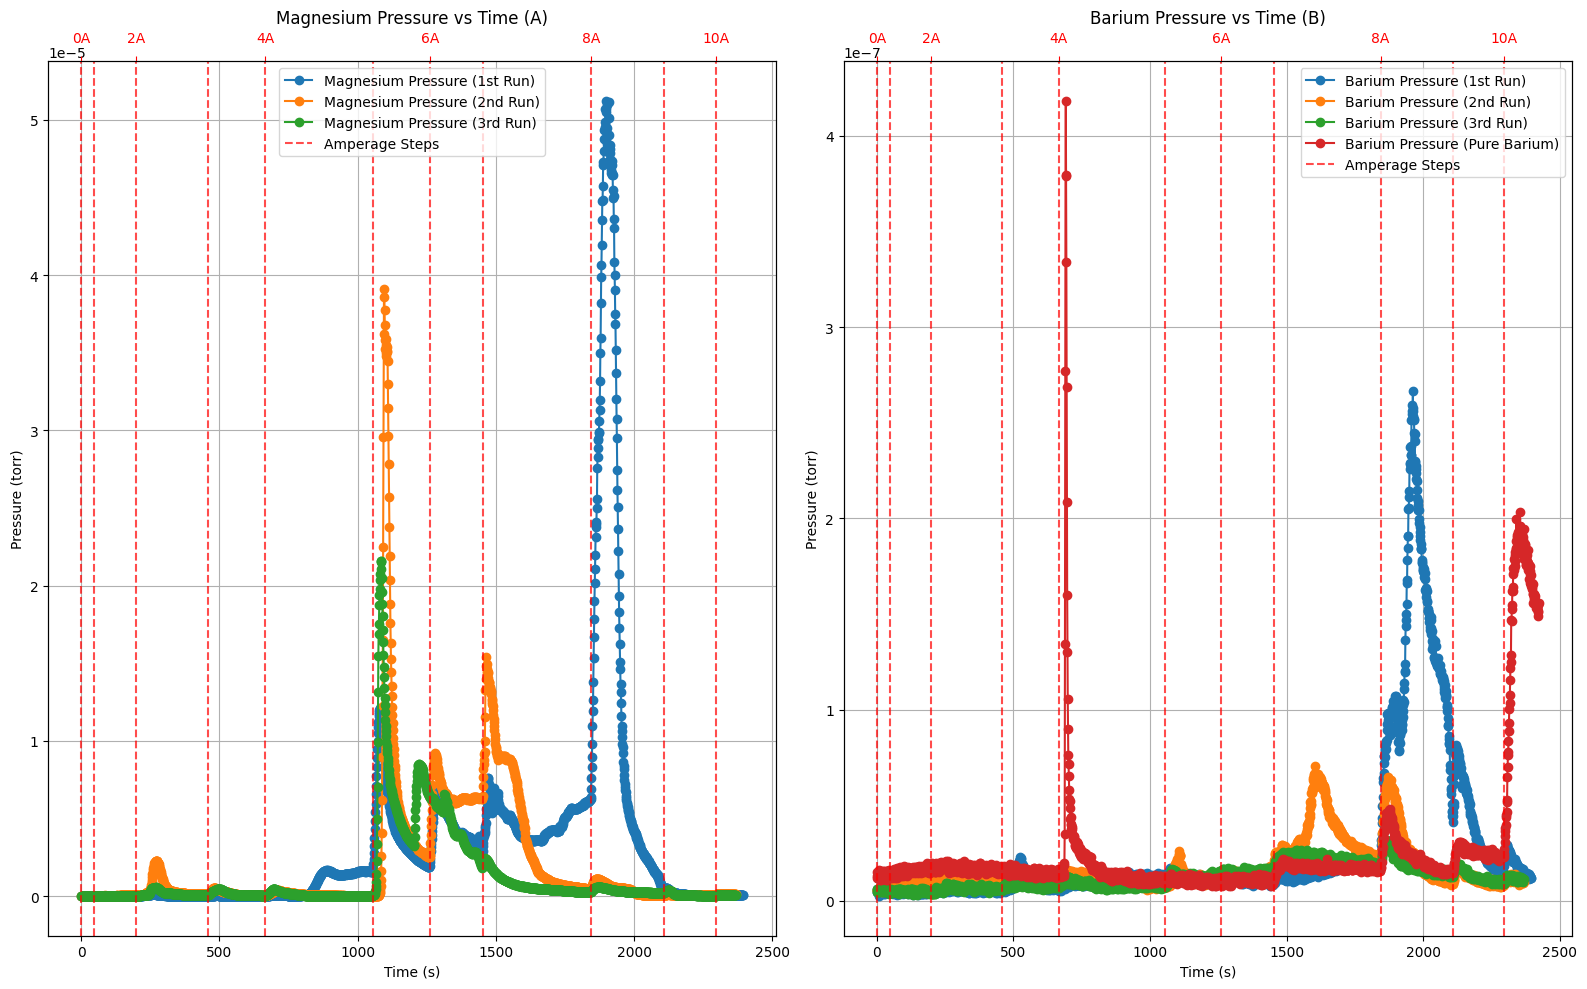

In [75]:
plt.figure(figsize=(16, 10))

# Left subplot
plt.subplot(1, 2, 1)
plt.plot(df['Time'], df['Magnesium_24amu'], marker='o', linestyle='-', label='Magnesium Pressure (1st Run)')
plt.plot(df2['Time'], df2['Magnesium_24amu'], marker='o', linestyle='-', label='Magnesium Pressure (2nd Run)')
plt.plot(df3['Time'], df3['Magnesium_24amu'], marker='o', linestyle='-', label='Magnesium Pressure (3rd Run)')

for i, t in enumerate(time_s):
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Pressure (torr)')
plt.title('Magnesium Pressure vs Time (A)')
plt.grid()

# Add amperage to legend
amperage_line = mlines.Line2D([], [], color='red', linestyle='--', alpha=0.7, label='Amperage Steps')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(amperage_line)
labels.append('Amperage Steps')
plt.legend(handles=handles, labels=labels)

# Labels the amperage Steps
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
key_indices = [0, 2, 4, 6, 8, 10]  # Show 0A, 2A, 4A, 6A, 8A, 10A
key_times = [time_s[i] for i in key_indices if i < len(time_s)]
key_labels = [f'{i}A' for i in key_indices if i < len(time_s)]
ax2.set_xticks(key_times)
ax2.set_xticklabels(key_labels, fontsize=10)
ax2.tick_params(axis='x', colors='red', pad=8)

# Right subplot
plt.subplot(1, 2, 2)
plt.plot(df['Time'], df['Barium_138amu'], marker='o', linestyle='-', label='Barium Pressure (1st Run)')
plt.plot(df2['Time'], df2['Barium_138amu'], marker='o', linestyle='-', label='Barium Pressure (2nd Run)')
plt.plot(df3['Time'], df3['Barium_138amu'], marker='o', linestyle='-', label='Barium Pressure (3rd Run)')
plt.plot(df4['Time'], df4['Barium_138amu'], marker='o', linestyle='-', label='Barium Pressure (Pure Barium)')

for i, t in enumerate(time_s):
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Pressure (torr)')
plt.title('Barium Pressure vs Time (B)')
plt.grid()

# Add amperage to legend
amperage_line = mlines.Line2D([], [], color='red', linestyle='--', alpha=0.7, label='Amperage Steps')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(amperage_line)
labels.append('Amperage Steps')
plt.legend(handles=handles, labels=labels)
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(key_times)
ax2.set_xticklabels(key_labels, fontsize=10)
ax2.tick_params(axis='x', colors='red', pad=8)

plt.tight_layout()
plt.show()

Table comparing the system pressures with the temperature readings for each test.

In [76]:
comp_df = pd.DataFrame({'1st Run Temp (C)': test_1temp,
                        'pressure1 (mbar)': pressure1,
                        '2nd Run Temp (C)': test_2temp,
                        'pressure2 (mbar)': pressure2,
                        '3rd Run Temp (C)': test_3temp, 
                        'pressure3 (mbar)': pressure3,
                        'Pure Ba Temp (C)': test_4temp,
                        'pressure4 (mbar)': pressure4})
comp_df

,1st Run Temp (C),pressure1 (mbar),2nd Run Temp (C),pressure2 (mbar),3rd Run Temp (C),pressure3 (mbar),Pure Ba Temp (C),pressure4 (mbar)
0,26.0,0.000003,38.5,0.000003,29.0,0.000003,26.7,0.000005
1,55.6,0.000004,66.6,0.000004,61.2,0.000004,58.6,0.000005
2,134.3,0.000014,158.2,0.000005,156.4,0.000005,159.5,0.000005
3,237.4,0.000040,256.5,0.000010,253.5,0.000006,249.6,0.000005
4,343.3,0.000016,343.9,0.000012,335.9,0.000012,325.7,0.000012
5,415.9,0.000009,403.9,0.000007,395.0,0.000016,385.1,0.000003
6,476.2,0.000006,468.3,0.000005,453.4,0.000003,451.9,0.000005
7,536.1,0.000005,538.6,0.000003,508.1,0.000002,478.3,0.000003
8,603.1,0.000005,584.7,0.000003,554.2,0.000002,490.5,0.000002
9,646.2,0.000004,627.4,0.000003,591.8,0.000002,536.6,0.000002


# Honig-Kramer Pressure Curves

In [77]:
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle

In [78]:
# Results taken from Honig and Kramer, 1962, RCA Laboraties (Cited in Summary Paper)

def honig_kramer_equation(T, A, B, C, D):
    return A/T + B*np.log10(T) + C*T + D

pressure_levels = np.array([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])  # in mmHg

barium_temps = np.array([560, 600, 640, 690, 740, 810, 900, 1000, 1140, 1310, 1570])
magnesium_temps = np.array([462, 490, 524, 560, 603, 655, 715, 790, 885, 1000, 1175])

In [79]:
ba_popt, _ = curve_fit(honig_kramer_equation, barium_temps, np.log10(pressure_levels),
                       p0= [-8000, 0.5, -1e-5, 15], maxfev=10000)

ba_A, ba_B, ba_C, ba_D = ba_popt

mg_popt, _ = curve_fit(honig_kramer_equation, magnesium_temps, np.log10(pressure_levels),
                       p0= [-7000, 0.5, -1e-5, 12], maxfev=10000)

mg_A, mg_B, mg_C, mg_D = mg_popt

print(f"Barium: A={ba_A}, B={ba_B}, C={ba_C}, D={ba_D}")
print(f"Magnesium: A={mg_A}, B={mg_B}, C={mg_C}, D={mg_D}")

def barium_vapor_pressure(temp_cel):
    temp_kel = temp_cel + 273.15
    log10_P = ba_A/temp_kel + ba_B*np.log10(temp_kel) + ba_C*temp_kel + ba_D
    return 10**log10_P  # in mmHg

def magnesium_vapor_pressure(temp_cel):
    temp_kel = temp_cel + 273.15
    log10_P = mg_A/temp_kel + mg_B*np.log10(temp_kel) + mg_C*temp_kel + mg_D
    return 10**log10_P  # in mmHg

T_cel = np.linspace(0, 1000, 1000)
ba_vp = barium_vapor_pressure(T_cel)
mg_vp = magnesium_vapor_pressure(T_cel)

Barium: A=-10914.812462753775, B=-7.946769019941499, C=0.0010584446320483169, D=32.69162343655279
Magnesium: A=-7844.3329511638, B=1.91966204720329, C=-0.0015132674993254811, D=4.568909219944044


/var/folders/hn/_yk3p7wx40j2d5rpwxm35r1m0000gn/T/ipykernel_71519/711497338.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'upper left')


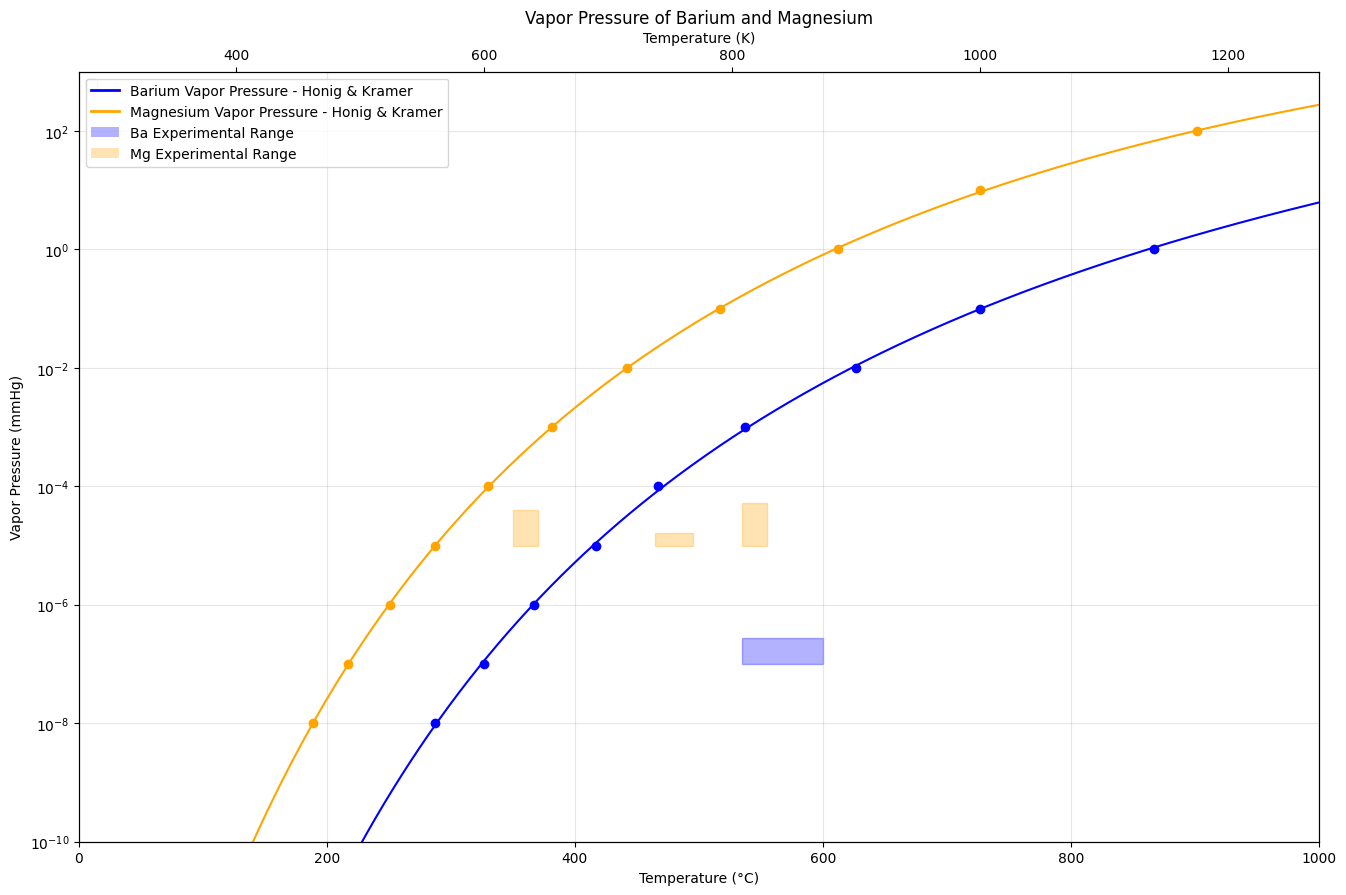

In [80]:
plt.figure(figsize=(16, 10))
plt.semilogy(T_cel, ba_vp, color='blue')
plt.semilogy(T_cel, mg_vp, color='orange')

plt.semilogy(magnesium_temps - 273.15, pressure_levels, 'o', color='orange')
plt.semilogy(barium_temps - 273.15, pressure_levels, 'o', color='blue')
plt.xlim(0, 1000)
plt.ylim(1e-10, 1e3)
plt.xlabel('Temperature (°C)')
plt.ylabel('Vapor Pressure (mmHg)')
plt.title('Vapor Pressure of Barium and Magnesium')

plt.legend(loc = 'upper left')
plt.grid(True, alpha=0.3)
plt.grid(True, which='minor', alpha=0.1)


mg_temp_ranges = [[350, 370], [465, 495], [535, 555]]
mg_pressure_ranges = [[1e-5, 3.95e-5], [1e-5, 1.65e-5], [1e-5, 5.2e-5]]
ba_temp_ranges = [[535, 600]]
ba_pressure_ranges = [[1e-7, 2.75e-7]]

ax = plt.gca()

for i in range(len(mg_temp_ranges)):
    mg_rect = Rectangle((mg_temp_ranges[i][0], mg_pressure_ranges[i][0]),
                        mg_temp_ranges[i][1] - mg_temp_ranges[i][0],
                        mg_pressure_ranges[i][1] - mg_pressure_ranges[i][0],
                        color='orange', alpha=0.3)
    ax.add_patch(mg_rect)

for i in range(len(ba_temp_ranges)):
    ba_rect = Rectangle((ba_temp_ranges[i][0], ba_pressure_ranges[i][0]),
                        ba_temp_ranges[i][1] - ba_temp_ranges[i][0],
                        ba_pressure_ranges[i][1] - ba_pressure_ranges[i][0],
                        color='blue', alpha=0.3)
    ax.add_patch(ba_rect)
    
from matplotlib.patches import Patch
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Barium Vapor Pressure - Honig & Kramer'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Magnesium Vapor Pressure - Honig & Kramer'),
    Patch(facecolor='blue', alpha=0.3, label='Ba Experimental Range'),
    Patch(facecolor='orange', alpha=0.3, label='Mg Experimental Range')
]

ax3 = plt.gca().twiny()
ax3.set_xlim(273.15, 1273.15)
ax3.set_xlabel('Temperature (K)')

plt.legend(handles=legend_elements, loc='upper left')

plt.show()